In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set up file read/folder structure
os.chdir("C:\\Users\\erroden\\Desktop\\ML_Guild\\mlg_02_us\\Capstone")

# Local Sources
# Initial focus will be on the airline data set but others may be stitched on to enrich the data
airline = pd.read_csv("data\\airline_2.csv")

airport = pd.read_csv("data\\airport.csv")
lounge = pd.read_csv("data\\lounge.csv")
seat = pd.read_csv("data\\seat.csv")

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Add on text length as an extra data point - https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9
airline["text_len"] = airline.content.apply(len)

In [8]:
airline.drop(airline.columns[0], axis=1, inplace=True) # drop index column

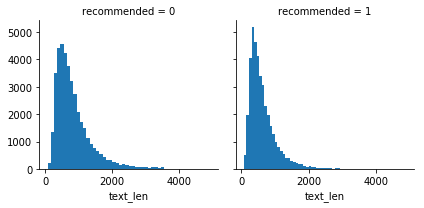

In [9]:
# visualize how words compare with recommended

g = sns.FacetGrid(data=airline, col='recommended')
g.map(plt.hist, 'text_len', bins=50)

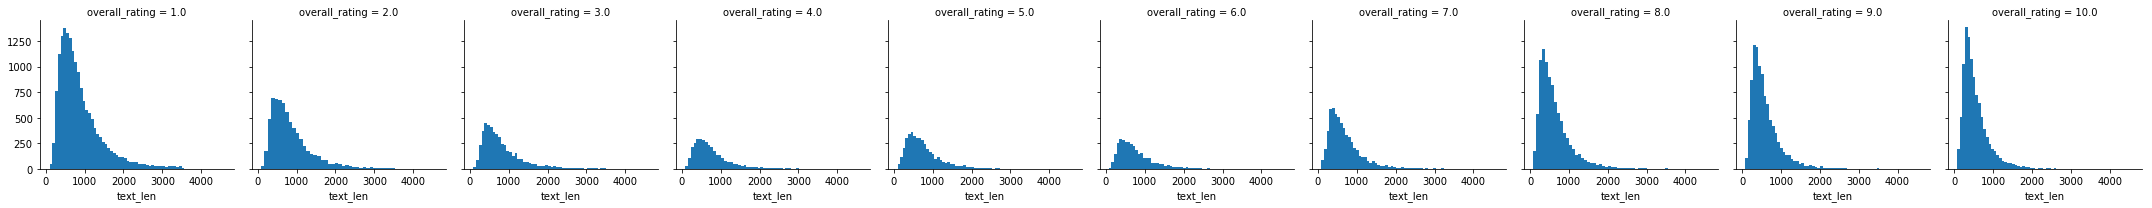

In [10]:
# visualize how words compare with recommended overall_rating

g = sns.FacetGrid(data=airline, col='overall_rating')
g.map(plt.hist, 'text_len', bins=50)

In [11]:
# generate tokens
airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

airline['tokens'].head()

0    [We, were, traveling, from, Paris, to, Skopje,...
1    [Ljubljana, to, Munich., Adria's, checkin, sys...
2    [A, very, unpleasant, experience, for, my, fam...
3    [Frankfurt, to, Ljubljana., Flight, was, very,...
4    [Ljubljana, to, Frankfurt., Flight, delayed, f...
Name: tokens, dtype: object

Looks like it's off to a good start. 

In [12]:
stops = set(stopwords.words('english'))

In [13]:
airline['clean'] = airline['tokens'].apply(lambda x: [word for word in x if word not in stops])

In [14]:
airline['clean'] = airline['clean'].apply(lambda x: [word for word in x if re.search('^[a-zA-Z]+', word)])

In [15]:
# Lemmatizer 
lemmatizer = nltk.WordNetLemmatizer()

airline['clean'] = airline['clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [16]:
airline['ready'] =  airline['clean'].apply(lambda x: ' '.join(x))

In [22]:
# Vectorize and fit the model

from sklearn.feature_extraction.text import TfidfVectorizer

# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

In [23]:
X.shape # records x tokens

(79802, 235)

In [24]:
# Classification using tfidf and recommendation as output variable

y = airline.recommended

In [25]:
# logistic regression

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9286898953759015

Text(0,0.5,'True Positive Rate (Sensitivity)')

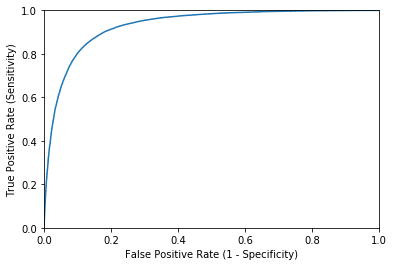

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [27]:
# Now add in sentiment

from textblob import TextBlob, Word

airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

# create a text blob column 
airline['blob'] = airline.content.apply(lambda x: TextBlob(x))

In [28]:
airline.blob.head()

0    (W, e,  , w, e, r, e,  , t, r, a, v, e, l, i, ...
1    (L, j, u, b, l, j, a, n, a,  , t, o,  , M, u, ...
2    (A,  , v, e, r, y,  , u, n, p, l, e, a, s, a, ...
3    (F, r, a, n, k, f, u, r, t,  , t, o,  , L, j, ...
4    (L, j, u, b, l, j, a, n, a,  , t, o,  , F, r, ...
Name: blob, dtype: object

In [29]:
# get polarity scores

airline['polarity'] = [sent.sentiment.polarity for sent in airline.blob]

In [30]:
airline.head()[['polarity', 'content']]

,polarity,content
0,-0.001667,We were traveling from Paris to Skopje on May ...
1,-0.007500,Ljubljana to Munich. Adria's checkin system is...
2,0.037111,A very unpleasant experience for my family. We...
3,0.206667,Frankfurt to Ljubljana. Flight was very comfor...
4,0.181345,Ljubljana to Frankfurt. Flight delayed for mor...


In [31]:
airline.content[2] # check to see if content matches sentient

"A very unpleasant experience for my family. We bought two return flights (Ljubljana-Prague-Ljubljana, Ljubljana-Warsaw-Ljubljana), and several days before departure both direct flights from and to Prague were canceled and a flight to Warsaw was merged with Prague flight (so added necessary stopover). Instead of a direct flight to Prague Adria Airways finally offered a transfer via Munich. When we arrived at the airport (21/6/2018), we found that the flight to Munich had more than an hour of delay, and therefore it was not possible to catch the next flight from Munich to Prague. The flight to Munich was full of people from the original canceled flight to Prague, who subsequently wanted to continue to Prague. Although the Adria Airways staff were present at the airport, no one came to inform the passengers and the result was tremendous confusion and lack of information. Ljubljana airport servicing staff finally informed us that Adria Airways staff refused to come! Also wasn't possible t

In [32]:
# logistic regression using sentiment/polarity only

X = airline.polarity
X = X.values.reshape(-1,1)
y = airline.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.8851731594453266

This performed slightly worse than using just the tfidf

Text(0,0.5,'True Positive Rate (Sensitivity)')

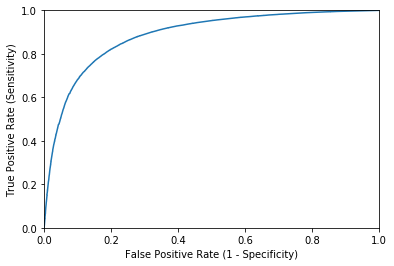

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

**Sentiment alone performs more poorly than using a tfidf, but not terrible performance

*What if we use both?

In [34]:
# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

In [35]:
X.polarity = airline.polarity

In [36]:
'''
Would I want to normalize this data now? I think not because I don't believe a distance measure is applied.
'''

"\nWould I want to normalize this data now? I think not because I don't believe a distance measure is applied.\n"

In [37]:
# without normalization
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9286898953759015

In [38]:
# with normalization - no change so not needed
from sklearn.preprocessing import normalize 

logreg = LogisticRegression()
cross_val_score(logreg, normalize(X), y, cv=5, scoring='roc_auc').mean()

0.9286898953759015

Text(0,0.5,'True Positive Rate (Sensitivity)')

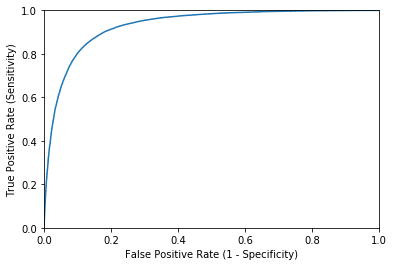

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

Similar performance to just using the tfidf

Now lets add additional features to the feature set 

In [40]:
airline.columns

Index(['aircraft', 'cabin_flown', 'cabin_staff_rating', 'date',
       'food_beverages_rating', 'ground_service_rating',
       'inflight_entertainment_rating', 'recommended', 'route',
       'seat_comfort_rating', 'type_traveller', 'value_money_rating',
       'wifi_connectivity_rating', 'airline_name', 'author', 'author_country',
       'content', 'date_published', 'link', 'overall_rating', 'title',
       'text_len', 'tokens', 'clean', 'ready', 'blob', 'polarity'],
      dtype='object')

In [41]:
'''
Select only columns we are interested in. These are the columns with sufficient data. 
Cabin flown is the only categorical that could be turned into a dummy variable and added but is not considered in this iteration 
'''


airline_filtered = airline[['overall_rating','seat_comfort_rating','cabin_staff_rating',
                            'food_beverages_rating', 'inflight_entertainment_rating',
                            'text_len', 'value_money_rating', 'polarity','ready', 'recommended']]

In [42]:
airline_filtered.shape

(79802, 10)

In [43]:
airline_filtered.dropna(inplace=True)

airline_filtered.shape

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(50731, 10)

In [44]:
# generate tfidf
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline_filtered['ready'])

In [45]:
# Add additional columns to be included in the model

X.over_all_rating = airline_filtered.overall_rating
X.seat_comfort_rating = airline_filtered.seat_comfort_rating
X.cabin_staff_rating = airline_filtered.cabin_staff_rating
X.food_beverages_rating = airline_filtered.food_beverages_rating
X.inflight_entertainment_rating = airline_filtered.inflight_entertainment_rating
X.text_len = airline_filtered.text_len
X.value = airline_filtered.value_money_rating
X.polarity = airline_filtered.polarity

y = airline_filtered.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9364820369980101

Text(0,0.5,'True Positive Rate (Sensitivity)')

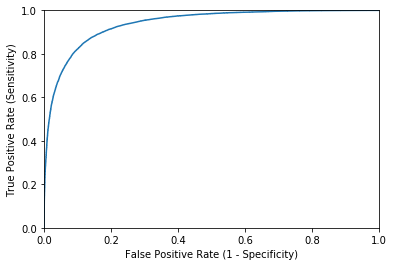

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

This is the best model yet. Additional algorithms should be tested and other approaches to handling missing data could be implemented. Also may want to focus in on just text since that could be more useful for doing things like scraping tweets. Additionally I should consider which measures are most valuable. In theory the false postives (incorrectly predicted would recommend) are the most detrimental because it represents the business an airline wouldn't take action to save are letting walk away. 